# 1. Sentiment Analysis of Movie Reviews using scikit-learn

In this notebook, I perform sentiment analysis of movie reviews using `scikit-learn`.

The dataset consists of 50k highly polarized (*clearly* favourable or unfavourable) movie reviews from IMBD. The set is partitioned into a labelled train set of 25k reviews and a labelled test set of 25k reviews. The reviews are preprocessed by lower-casing, removing HTML tags, and removing punctutation. The reviews are then tokenized, removing English stop words, and stemmed. Corpus vectorization is implemented using both `CountVectorizer` and `TfidfVectorizer`. Various classification models are trained and tested on the results.

## Imports

In [378]:
import matplotlib.pyplot as plt
import pandas as pd
import re

from nltk import PorterStemmer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

from scipy.stats import loguniform
from string import punctuation
from datasets import load_dataset

## Load IMDB Dataset

In [379]:
ds = load_dataset('imdb')
train, test = pd.DataFrame(ds['train']), pd.DataFrame(ds['test'])

Note that a label of 0 corresponds to a negative review (*i.e.,* thumbs-down) whereas a label of 1 corresponds to a positive review (*i.e.,* thumbs-up).

In [383]:
train.sample(5)

,text,label
9330,This is a movie about making a movie. Such mov...,0
24893,Just read the original story which is written ...,1
7299,"a romance without feeling, a drama of issues w...",0
24476,Greetings again from the darkness. Remember al...,1
5955,"I won't mention any of the plot, because, alth...",0


In [384]:
test.sample(5)

,text,label
4624,this film is what happens when people see like...,0
14465,You got to see it to believe it. Shot in Holly...,1
19084,This is a pretty good documentary. I'm not a s...,1
12049,"""The Final Comedown"" wants to ""say something"" ...",0
8781,Hollywood had a long love affair with bogus Ar...,0


## Exploratory Data Analysis

In [382]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


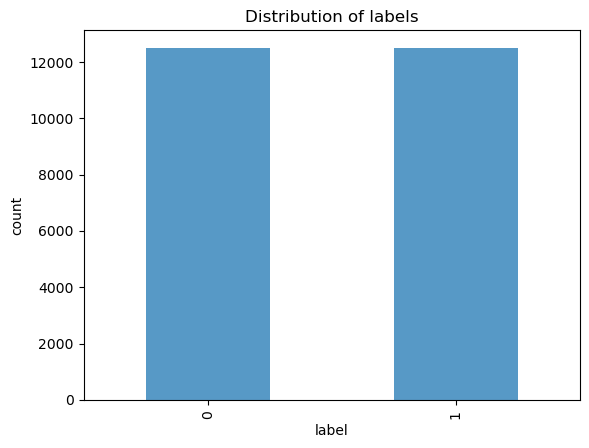

In [62]:
fig, ax = plt.subplots()
train.groupby('label').count().plot(kind='bar', alpha=0.75, ax=ax)
ax.set_ylabel('count')
ax.set_title('Distribution of labels')
ax.legend().set_visible(False)
plt.show()

From the above bar graph, the train set appears to be balanced. To confirm:

In [385]:
train['label'].value_counts()

label
0    12500
1    12500
Name: count, dtype: int64

It is instructive to read a handful of the reviews to better understand what is meant by "highly polarized."

In [65]:
thumbs_ups = train[train['label'] == 1]
thumbs_downs = train[train['label'] == 0]

In [390]:
thumbs_up_samples = thumbs_ups['text'].sample(3).to_list()
for sample in thumbs_up_samples:
    print(sample + '\n')

This is a pretty well known one so i won't get too deep into it. The basic story is about two teens who find out about a slimy alien blob of goo that arrives to earth via meteor. Human contact with this slime ball burns through flesh like acid. It also absorbs human bodies making it grow bigger. Nobody believes the teens (Steeve McQueen and his girlfriend) and when they finally do it seems that the blob can't be stopped. It's really well done for it's age and unlike a lot of other 50's flicks the pace is pretty fast. The story is very unique making it and a must see for any fan of old sci-fi and monster movies. If you can dig the gooey gore of 80s horror be sure to check out the remake from '88 as well.

This is easily the most underrated film inn the Brooks cannon. Sure, its flawed. It does not give a realistic view of homelessness (unlike, say, how Citizen Kane gave a realistic view of lounge singers, or Titanic gave a realistic view of Italians YOU IDIOTS). Many of the jokes fall fl

In [395]:
thumbs_down_samples = thumbs_downs['text'].sample(3).to_list()
for sample in thumbs_down_samples:
    print(sample + '\n')

Don't get me wrong, I'm a huge fan of many of Woody's movies, obviously his late 70's masterpieces (Annie Hall,Interiors, Manhattan)and most of his late 80's/early 90's dramas (Hannah, Crimes and Misdemeaners,Husbands and Wives) in fact I even liked some of his more recent efforts (Melinda, Anything Else, Small Time Crooks) but this was abysmal, I though it couldn't possibly be any worse than last years Match Point but how wrong I was.<br /><br />It was lazily plotted - basically a cross between Match Point, Manhattan Murder Mystery and Small Time Crooks,with all the jokes taken out - Woody seems to be on the way out as well, slurring most of his lines and delivering 'hilarious' catchphrases 'I mean that with all due respect...' over and over until the blandness of it all becomes to much to bare.<br /><br />I know that most actors are queuing up to work with him but they should at least read the script first - Scarlett Johansson and Hugh Jackman are so much better than this - and Woody

## Preprocessor

The preprocessor processes and cleans movie reviews through lower-casing, removing HTML tags, and removing punctuation. 

In [400]:
class Preprocessor(BaseEstimator, TransformerMixin):
    @staticmethod
    def strip_html(X):
        """Remove HTML tags from a corpus X."""
        return [re.sub(r'<[^>]+>', ' ', doc) for doc in X]

    @staticmethod
    def strip_forward_slashes(X):
        """Replace / by a space in a corpus X."""
        return [doc.replace('/', ' ') for doc in X]

    @staticmethod
    def strip_punctuation(X):
        """Remove punctuation from a corpus X."""
        def strip_punc_from_doc(doc: str) -> str:
            """Remove punctuation from a single document doc."""
            doc_trans = doc
            for p in punctuation:
                doc_trans = doc_trans.replace(p, '')
            return doc_trans
        return [strip_punc_from_doc(doc) for doc in X] 

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.Series):
            X = X.to_list()
            
        X_trans = X
        X_trans = [doc.lower() for doc in X_trans]
        X_trans = Preprocessor.strip_html(X_trans)
        X_trans = Preprocessor.strip_forward_slashes(X_trans)
        X_trans = Preprocessor.strip_punctuation(X_trans)
        
        return X_trans

To see Preprocessor in action, pick a random movie review:

In [418]:
preprocessor = Preprocessor()

doc = train['text'].sample()
doc_preprocessed = preprocessor.transform(doc)

print(doc.to_list()[0])
print()
print(doc_preprocessed[0])

Bizarre, trippy, forget-about-a-story-and-full-steam-ahead low budget sci-fi about the Williams family, living in the California desert. They become witness to a series of events that escalate in their level of strangeness; apparently, they've been caught in a time-space warp, where past, present and future collide.<br /><br />This is the excuse for a parade of highly amusing special effects - a constant light and sound show, dinosaur-like creatures that have at each other, a friendly and tiny little E.T. who enchants the granddaughter, and so on. This picture does show off a little imagination, if nothing else.<br /><br />Very nice music by Richard Band, engaging special effects work from the likes of David Allen, Randall William Cook, and Peter Kuran, and, importantly, a likable family are key assets. It generates a sense of child-like amazement; it may very well be that it's more of a romp for kids (or the kids inside many of us) who are able to gloss over any flaws in the narrative

## Tokenizer

The tokenizer removes English stop words and stems the corpus.

In [415]:
class Tokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, stemmer, stop_words=None):
        """
        Initialize a Tokenizer.

        :param stemmer: An instance of a word stemmer
        :param stop_words: A list of words to remove from the corpus
        """
        self.stemmer = stemmer
        self.stop_words = stop_words

    def remove_stop_words(self, X):
        """Remove stop words from a corpus X."""
        def remove_stop_words_from_doc(doc):
            """Remove stop words from a document doc."""
            doc_trans = []
            for word in doc:
                if word not in self.stop_words:
                    doc_trans.append(word)
            return doc_trans
        return [remove_stop_words_from_doc(doc) for doc in X]

    def stem(self, X):
        """Stem a corpus X."""
        def stem_doc(doc):
            """Stem a document doc."""
            return_doc = []
            for word in doc:
                return_doc.append(self.stemmer.stem(word))
            return return_doc
        return [stem_doc(doc) for doc in X]
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.Series):
            X = X.to_list()
            
        X_trans = X
        X_trans = [doc.split() for doc in X_trans]
        X_trans = self.remove_stop_words(X_trans)
        X_trans = self.stem(X_trans)
        X_trans = [' '.join(doc) for doc in X_trans]
        
        return X_trans

To see Tokenizer in action, transform the previously preprocessed movie review.

In [419]:
tokenizer = Tokenizer(PorterStemmer(), ENGLISH_STOP_WORDS)

doc_tokenized = tokenizer.transform(doc_preprocessed)

print(doc_preprocessed[0])
print()
print(doc_tokenized[0])

bizarre trippy forgetaboutastoryandfullsteamahead low budget scifi about the williams family living in the california desert they become witness to a series of events that escalate in their level of strangeness apparently theyve been caught in a timespace warp where past present and future collide  this is the excuse for a parade of highly amusing special effects  a constant light and sound show dinosaurlike creatures that have at each other a friendly and tiny little et who enchants the granddaughter and so on this picture does show off a little imagination if nothing else  very nice music by richard band engaging special effects work from the likes of david allen randall william cook and peter kuran and importantly a likable family are key assets it generates a sense of childlike amazement it may very well be that its more of a romp for kids or the kids inside many of us who are able to gloss over any flaws in the narrative or presentation  i found it hard to resist its a short and s

## Classification

In [420]:
X_train, X_test, y_train, y_test =\
    train['text'], test['text'], train['label'], test['label']

### Logistic Regression

In [421]:
def init_vectorizer(vectorizer):
    return vectorizer(
        max_df = 0.95,
        min_df = 0.01,
        max_features = 10_000,
        strip_accents='unicode'
    )

count_vectorizer = init_vectorizer(CountVectorizer)
tfidf_vectorizer = init_vectorizer(TfidfVectorizer)

logistic_regression = LogisticRegression(
    penalty='l2', 
    solver='saga',
    max_iter=500
)

pipe = Pipeline([
    ('preprocessor', Preprocessor()),
    ('tokenizer', Tokenizer(PorterStemmer(), ENGLISH_STOP_WORDS)),
    ('vectorizer', None),
    ('classifier', logistic_regression)
])

param_distributions = {
    'vectorizer': [count_vectorizer, tfidf_vectorizer],
    'classifier__C': loguniform(1e-3, 1e2),
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=15,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    refit=True,
    verbose=1
)

In [422]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/derek/anaconda3/envs/huggingface/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/derek/anaconda3/envs/huggingface/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/derek/anaconda3/envs/huggingface/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/derek/anaconda3/envs/huggingface/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/derek/anaconda3/envs/huggingface/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor', Preprocessor()),
                                             ('tokenizer',
                                              Tokenizer(stemmer=<PorterStemmer>,
                                                        stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                              'almost',
                                                                              'alone',
                                                                              'along',
                                                                              'already',
                                                                              'also',
                                                                              'although',
                                                                              'always',
                                                                              'am',
                                                                              'among',
                                                                              'amongst',
                                                                              'amoungst',
                                                                              'amount',
                                                                              'an',
                                                                              'and',
                                                                              'another',
                                                                              'any...
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7efd55c3f610>,
                                        'vectorizer': [CountVectorizer(max_df=0.95,
                                                                       max_features=10000,
                                                                       min_df=0.01,
                                                                       strip_accents='unicode'),
                                                       TfidfVectorizer(max_df=0.95,
                                                                       max_features=10000,
                                                                       min_df=0.01,
                                                                       strip_accents='unicode')]},
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=1)

In [ ]:
print(f'Best model: {search.best_params_}')
print(f'F1-score: {search.score(X_test, y_test)}')

Best model: {'classifier__C': 0.24456744707491074, 'vectorizer': TfidfVectorizer(max_df=0.95, max_features=10000, min_df=0.01,
                strip_accents='unicode')}
